# Retrieval 2: Timeseries 

:::{admonition} About this retrieval example
This example shows how to use the [rt1 python package](https://github.com/raphaelquast/rt1_model) together with [scipy optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) to setup a retrieval procedure to obtain:
- both static and dynamic parameters from a series of incidence-angle dependent $\sigma^0$ measurements.
:::

In [10]:
%matplotlib widget
from rt1_model import RT1, surface, volume, set_loglevel
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import numpy as np

rand = np.random.RandomState(123456)  # initialize a reproducible random state
set_loglevel("info")

## Specify simulation and fit parameters
### Set parameter values that are used to simulate the data

In [11]:
dB, sig0 = True, True

num = 100  # Number of measurements
incs = 30  # Available incidence angles per measurement
noise_sigma = 0.5 if dB is True else 1e-3  # Noise-level (sigma of gaussian noise)

inc = rand.normal(45, 10, (num, incs)).clip(20, 70)    # Incidence angles
N = rand.normal(0.25, 0.25, (num, 1)).clip(0.01, 0.5)  # NormBRDF values

sim_params = dict(tau=0.1, omega=0.1, N=N)  # Simulation parameter values
const_params = dict(t_s=0.4)  # Constant parameters (assumed to be known)

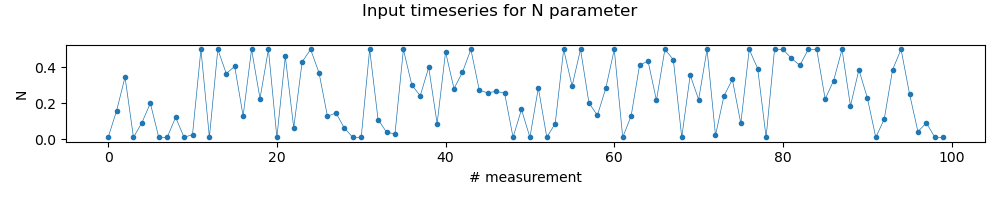

In [12]:
f, ax = plt.subplots(figsize=(10, 2))
f.canvas.header_visible = False
f.suptitle("Input timeseries for N parameter")
ax.plot(N, marker=".", lw=0.5)
ax.set_ylabel("N")
ax.set_xlabel("# measurement")
f.tight_layout()

### Set start values and boundaries for the fit

In [13]:
start_vals = dict(tau=0.3, omega=0.2, N=[0.3] * num)
bnd_vals = dict(tau=(0.01, 0.5), omega=(0.01, 0.5), N=[(0.01, 0.5)] * num)

## Setup RT1 and create a simulated dataset

In [14]:
V = volume.Isotropic()
SRF = surface.HG_nadirnorm(t="t_s", ncoefs=10)

R = RT1(V=V, SRF=SRF, int_Q=True, dB=dB, sig0=True)
R.set_monostatic(p_0=0)
R.NormBRDF = "N"  # Use a synonym for NormBRDF parameter

R.set_geometry(t_0=np.deg2rad(inc))
R.update_params(**sim_params, **const_params)

tot = R.calc()[0]
tot += rand.normal(0, noise_sigma, tot.shape)  # Add some random noise

18:14:04.068 INFO: Evaluating coefficients for interaction-term...
18:14:04.105 INFO: Coefficients extracted, it took 0.00582 sec.


## Setup scipy optimize to fit RT1 model to the data

In [15]:
param_names = list(sim_params)

def parse_params(x):
    """Map 1D parameter array to dict {parameter_name: value(s)}."""
    return dict(tau=x[0], omega=x[1], N=x[2:][:, np.newaxis])

def fun(x):
    """Calculate residuals."""
    R.update_params(**parse_params(x))
    res = (R.calc()[0] - tot).ravel()
    return res

def jac(x):
    """Calculate jacobian."""
    R.update_params(**parse_params(x))
    jac = R.jacobian(param_list=list(param_names), format="scipy_least_squares")
    return jac

# Unpack start-values and boundaries as required by scipy optimize
x0 = [start_vals["tau"], start_vals["omega"], *start_vals["N"]]
bounds = list(zip(*[bnd_vals["tau"], bnd_vals["omega"], *bnd_vals["N"]]))

res = least_squares(
    fun=fun,
    x0=x0,
    bounds=bounds,
    jac=jac,
    ftol=1e-8,
    gtol=1e-8,
    xtol=1e-3,
    verbose=2,
)

# Unpack found parameters
found_params = parse_params(res.x)
# Calcuate total backscatter based on found parameters
found_tot = R.calc(**found_params)[0]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.8790e+04                                    8.65e+03    
       1              2         1.3913e+04      2.49e+04       1.49e+00       5.84e+03    
       2              3         3.2003e+03      1.07e+04       4.23e-01       2.93e+03    
       3              4         9.8933e+02      2.21e+03       3.52e-01       1.48e+03    
       4              5         5.2242e+02      4.67e+02       2.21e-01       3.10e+03    
       5              6         3.9465e+02      1.28e+02       1.81e-01       2.23e+03    
       6              7         3.6868e+02      2.60e+01       4.42e-02       1.12e+03    
       7              8         3.6406e+02      4.62e+00       2.67e-03       2.68e+02    
`xtol` termination condition is satisfied.
Function evaluations 8, initial cost 3.8790e+04, final cost 3.6406e+02, first-order optimality 2.68e+02.


In [16]:
from IPython.display import HTML, display
s = ["<table>",
     "<caption>Retrieved Parameters</caption>",
     "<tr><th>Parameter</th><th>Target value</th><th>Start value</th><th>Retrieved value</th><th>(Target - Retrieved)</th></tr>",
     *(f"<tr><td>{key if isinstance(val, (int, float, np.number)) else key + ' <b>(mean)</b>'} </td>"
       f"<td> {np.mean(sim_params[key]):.3f} </td>"
       f"<td>{np.mean(start_vals[key]): .3f}</td>" 
       f"<td> {np.mean(val):.3f}</td>"
       f"<td>{np.mean(val - sim_params[key]): .3f}</td></tr>" 
       for key, val in found_params.items()),
     "</table>"]
display(HTML("\n".join(s)))

Parameter,Target value,Start value,Retrieved value,(Target - Retrieved)
tau,0.100,0.300,0.097,-0.003
omega,0.100,0.200,0.096,-0.004
N (mean),0.251,0.300,0.250,-0.001


## Visualize Results
### Plot timeseries

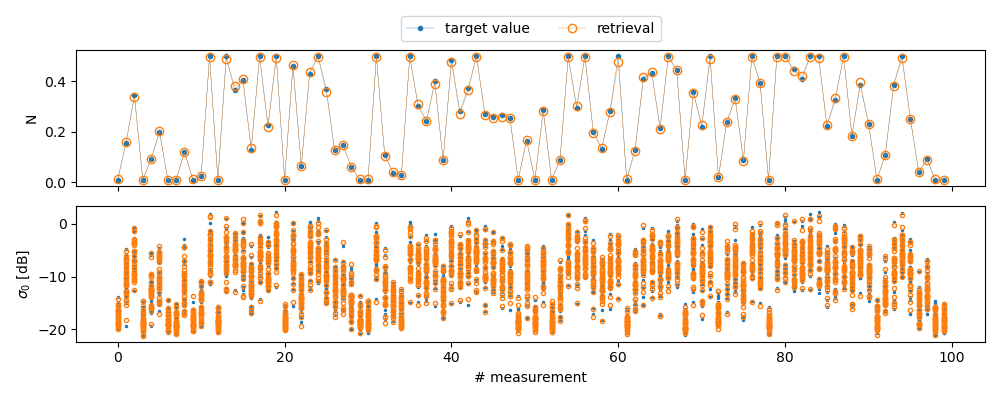

In [17]:
f, (ax, ax2) = plt.subplots(2, figsize=(10, 4), sharex=True)
f.canvas.header_visible = False

ax.set_ylabel("N")
ax2.set_ylabel(r"$\sigma_0$ [dB]")
ax2.set_xlabel("# measurement")

ax.plot(sim_params["N"], marker=".", lw=0.25, label="target value")
ax.plot(
    found_params["N"], marker="o", lw=0.25, markerfacecolor="none", label="retrieval"
)

ax2.plot(tot, lw=0, marker=".", c="C0", ms=3)
ax2.plot(found_tot, lw=0, marker="o", markerfacecolor="none", c="C1", ms=3)

ax.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, 1.3))
f.tight_layout()

### Initialize analyzer widget and overlay results

18:14:04.747 INFO: Evaluating coefficients for interaction-term...
18:14:04.777 INFO: Coefficients extracted, it took 0.00782 sec.


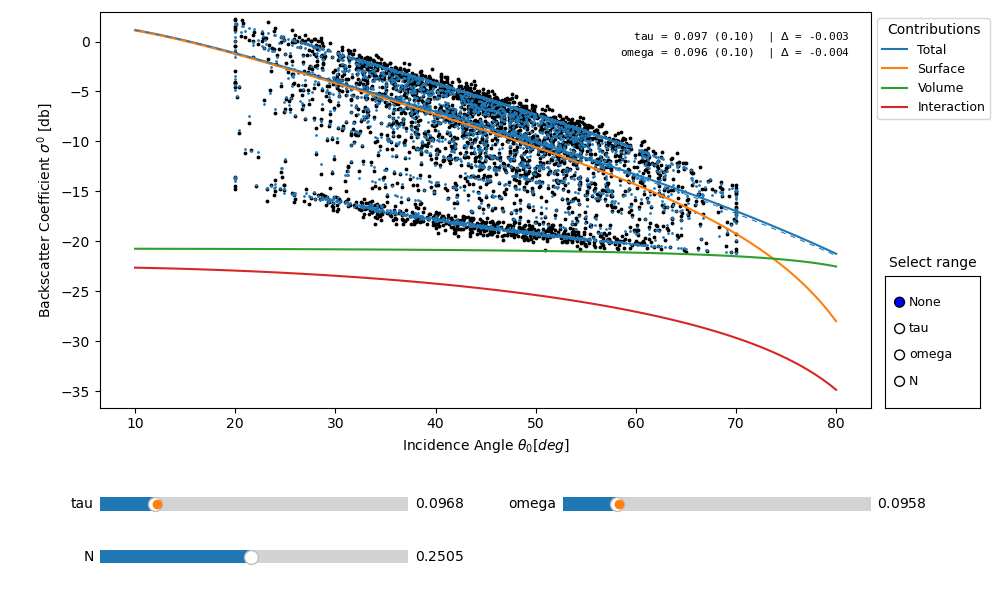

In [18]:
analyze_params = {key: (0.01, 0.5, found_params[key].mean()) for key in param_names}
ana = R.analyze(**analyze_params)

# Plot fit-data on top
ana.ax.scatter(inc, tot, c="k", s=3, zorder=0)
ana.ax.scatter(inc, found_tot, c="C0", s=1, zorder=0)

# Indicate fit-results in slider-axes
for key, s in ana.sliders.items():
    if key in ["tau", "omega"]:
        s.ax.plot(sim_params[key], np.mean(s.ax.get_ylim()), marker="o")

# Add text for static parameters
t = ana.f.text(
    0.6,
    0.95,
    "\n".join(
        [
            f"{key:>8} = {found_params[key]:.3f} ({sim_params[key]:.2f})  "
            rf"| $\Delta$ = {found_params[key] - sim_params[key]: .3f}"
            for key in ["tau", "omega"]
        ]
    ),
    va="top",
    fontdict=dict(family="monospace", size=8),
)